# Customer Segmentation using K-Means Algorithm for Seasonal Profiles

The individual files should contain 3 months data of energy consumption in 15 minute interval

In [1]:
import polars as pl
import glob
from pathlib import Path
import os
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import logging
import re

from tslearn.clustering import TimeSeriesKMeans 

logging.getLogger('matplotlib.font_manager').disabled = True

from validation import validation

## Select the season for clustering

In [2]:
input_folder = Path("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_cleaned")

pattern = str(input_folder / "*CH*.csv")
file_paths = glob.glob(pattern)

def day_avg_preprocess_season(df, season):
    # Parse the timestamp column
    
    if season == "spring":
        timestamp_range = pl.datetime_range(datetime(2024,3,1), datetime(2024,5,31), "1d",eager=True)
    elif season == "summer":
        timestamp_range = pl.datetime_range(datetime(2024,6,1), datetime(2024,8,31), "1d",eager=True)
    elif season == "autumn":
        timestamp_range = pl.datetime_range(datetime(2024,8,31,23), datetime(2024,11,30), "1d",eager=True)
    else:
        timestamp_range = pl.concat([pl.datetime_range(datetime(2024,1,1), datetime(2024,2,28), "1d",eager=True), 
                                     pl.datetime_range(datetime(2024,12,1), datetime(2024,12,31), "1d",eager=True)])
    df = df.with_columns(
        pl.col("zeitpunkt").str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%S%z", strict=False).alias("zeitpunkt_dt")
    )

    timestamp_range = timestamp_range.cast(pl.Date)

    # In your function, ensure the datetime column is cast to Date for comparison
    df = df.with_columns(
        pl.col("zeitpunkt_dt").dt.date().alias("date_only")
    )

    df = df.filter(
        pl.col("date_only").is_in(timestamp_range.implode())
    )
    
    # Sort by datetime
    df = df.sort("zeitpunkt_dt")
    
    # Filter only Saturdays and Sundays
    #df = df.filter(pl.col("zeitpunkt_dt").dt.weekday().is_in([5, 6]))
    
    # Extract time_of_day as time component
    df = df.with_columns(
        pl.col("zeitpunkt_dt").dt.time().alias("time_of_day")
    )
    
    # Group by time_of_day and compute mean
    day_avg = (
        df.group_by("time_of_day")
          .agg(pl.col("bruttolastgang_kwh").mean().alias("day_avg_bruttolastgang_kwh"))
          .sort("time_of_day")
    )
    
    return day_avg

def normalize(df):
    """ Normalize the 'day_avg_bruttolastgang_kwh' column by its max value and overwrite the original column """
    max_val = df.select(pl.max("day_avg_bruttolastgang_kwh"))['day_avg_bruttolastgang_kwh'][0]
    
    if max_val == 0:
        # Avoid division by zero, leave values unchanged
        df = df.with_columns(
            pl.col("day_avg_bruttolastgang_kwh")
        )
    else:
        # Overwrite original column with normalized values
        df = df.with_columns(
            (pl.col("day_avg_bruttolastgang_kwh") / max_val).alias("day_avg_bruttolastgang_kwh")
        )
    
    return df

base_output_folder = Path("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_seasonal_normalized")

for season in ["spring", "summer", "autumn", "winter"]:
    # Create a folder for the current season
    season_folder = base_output_folder / f"SM_DATA_seasonal_normalized_{season}"
    season_folder.mkdir(parents=True, exist_ok=True)
    
    for file_path in file_paths:
        df = pl.read_csv(file_path)
        day_avg = day_avg_preprocess_season(df, season)
        day_avg = normalize(day_avg)
        
        filename = os.path.basename(file_path)  # Extract original filename
        output_file = season_folder / filename  # Write to season-specific folder
        
        day_avg.write_csv(output_file)

In [3]:
season = "winter"

pattern = f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_seasonal_normalized/SM_DATA_seasonal_normalized_{season}/*CH*.csv"
file_paths = glob.glob(pattern)

print(f"Number of files for season {season}: {len(file_paths)}")

Number of files for season winter: 1464


In [4]:
n_timestamps = 96

data_list = []
filename_list = []

pattern = re.compile(r"(CH[^_\.]*)")  # Matches 'CH' followed by any chars except _ or .

for idx, file_path in enumerate(file_paths):
    df = pl.read_csv(file_path)
    if len(df) == n_timestamps:
        values_array = df["day_avg_bruttolastgang_kwh"].to_numpy().reshape((1, n_timestamps, 1))
        data_list.append(values_array)
        
        base = os.path.basename(file_path)
        match = pattern.search(base)
        if match:
            filename_list.append(match.group(1))
        else:
            filename_list.append(base)  # fallback to full basename if no CH... found

if data_list:
    data_3d = np.concatenate(data_list, axis=0)
    print(f"Shape of the 3D array: {data_3d.shape}")

print(filename_list[:10])  # Preview first 10 extracted CH... names

train_data = data_3d

Shape of the 3D array: (1464, 96, 1)
['CH1018601234500000000000000040851', 'CH1018601234500000000000000047828', 'CH1018601234500000000000000112970', 'CH1018601234500000000000000076787', 'CH1018601234500000000000000067786', 'CH1018601234500000000000000036798', 'CH1018601234500000000000000065363', 'CH1018601234500000000000000065862', 'CH1018601234500000000000000024655', 'CH1018601234500000000000000070197']


In [5]:
n_clusters = 5  # Number of clusters, you can adjust this
max_iterations =100

kmeans = TimeSeriesKMeans(n_clusters=n_clusters,max_iter=max_iterations, verbose=True, random_state=42, n_jobs=-1)
clusters_train = kmeans.fit_predict(train_data)

3.072 --> 2.233 --> 2.191 --> 2.179 --> 2.168 --> 2.160 --> 2.156 --> 2.153 --> 2.151 --> 2.149 --> 2.149 --> 2.148 --> 2.148 --> 2.148 --> 2.147 --> 2.146 --> 2.145 --> 2.145 --> 2.145 --> 2.145 --> 2.145 --> 


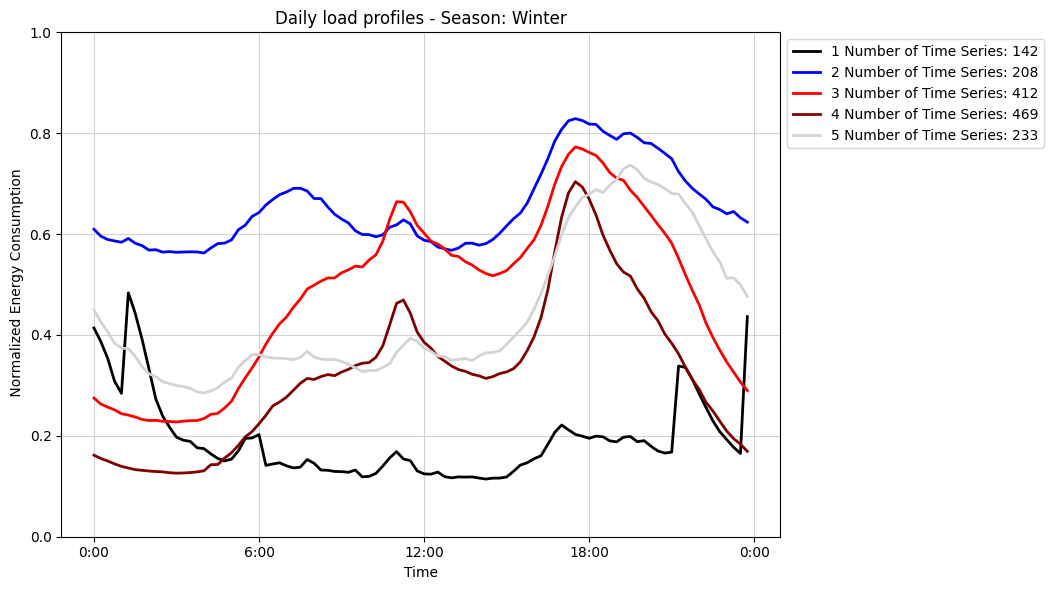

In [6]:
labels = ['0:00','6:00','12:00','18:00','0:00']

colors= ['black','blue','red','maroon','lightgrey','pink','darkgrey','darkblue','skyblue','indianred','purple','magenta','pink','violet']

def plot_clusters_season():
    
    plt.figure(figsize=(8,6))
    for cluster_idx in range(n_clusters):
        # Get all time series in this cluster
        cluster_data = train_data[clusters_train == cluster_idx]
        cluster_indices = np.where(clusters_train == cluster_idx)[0]    
    
        # Calculate the mean time series for the cluster
        mean_time_series = np.mean(cluster_data, axis=0)
    
        # Plot the mean time series
        cluster_no = cluster_idx+1
        plt.plot(range(1,97), mean_time_series.ravel(), 
                label= f'{cluster_no} Number of Time Series: {len(cluster_indices)}',
                linewidth =2, color=colors[cluster_idx] )
    plt.title(f'Daily load profiles - Season: {season.capitalize()}')
    plt.xlabel("Time")
    plt.ylabel(" Normalized Energy Consumption")
    plt.ylim(0,1)
    #plt.xticks(range(1,108,12),labels=labels)
    plt.xticks(range(1,120,24),labels=labels)
    plt.tight_layout()
    #plt.legend()
    #plt.margins(0)
    plt.grid(True, color = 'lightgray')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.savefig(
    "/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/Plots_seasonal/" \
    "seasonal_clusters_" + season + ".png",
    bbox_inches='tight',
    dpi=600
)
    plt.show()
    

plot_clusters_season()

In [7]:
# saves the found clusters in a csv file with the corresponding household IDs

# Convert filename_list items to strings
house_ids = [str(h) for h in filename_list]

# Creates Polars DataFrame with house IDs and clusters
result_df = pl.DataFrame({
    "house_id": house_ids,
    "cluster": clusters_train + 1
}).sort("cluster")
result_df.write_csv(f'/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/hourly_avg_clustering_{season}.csv')

In [8]:


# Read the alle_mittelwerte file
alle_mittelwerte_df = pl.read_csv("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/alle_mittelwerte.csv")  # Adjust path as needed

# Normalize keys in all DataFrames for clean join
# Normalize keys
result_df = result_df.with_columns(
    pl.col("house_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

alle_mittelwerte_df = alle_mittelwerte_df.with_columns(
    pl.col("file_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

result_df = result_df.join(
    alle_mittelwerte_df.select([
        "ch_id_clean",
        "average_daily_consumption",
        f'avg_daily_{season}' 
    ]),
    on="ch_id_clean",
    how="left"
)
# Now select in the desired order
result_df = result_df.select([
    "house_id",
    "cluster",
    "average_daily_consumption",
    f'avg_daily_{season}' 
])

#print(result_df.head())

cluster_summary = result_df.group_by("cluster").agg([
    pl.count("house_id").alias("num_households"),
    pl.mean("average_daily_consumption").alias("average_yearly_consumption [kWh]"),
    pl.mean(f'avg_daily_{season}').alias(f'avg_daily_{season} [kWh]' )
]).sort("cluster")

#print(cluster_summary)

# Compute overall averages
overall_yearly_avg = result_df["average_daily_consumption"].mean()
overall_seasonal_avg = result_df[f'avg_daily_{season}'].mean()

cluster_summary = cluster_summary.with_columns([
    pl.col("cluster").cast(pl.Utf8)
])
summary_row = pl.DataFrame({
    "cluster": ["Combined"],  # Use 0 or a valid UInt32 value for summary row
    "num_households": [result_df["house_id"].n_unique()],
    "average_yearly_consumption [kWh]": [overall_yearly_avg],
    f"avg_daily_{season} [kWh]": [overall_seasonal_avg]
})

# Cast to match schema, e.g. cluster and num_households to UInt32
summary_row = summary_row.with_columns([
    pl.col("cluster").cast(cluster_summary["cluster"].dtype),
    pl.col("num_households").cast(cluster_summary["num_households"].dtype)
])

# Concatenate now that dtypes match
final_summary = pl.concat([cluster_summary, summary_row])

print(final_summary)

shape: (6, 4)
┌──────────┬────────────────┬─────────────────────────────────┬────────────────────────┐
│ cluster  ┆ num_households ┆ average_yearly_consumption [kW… ┆ avg_daily_winter [kWh] │
│ ---      ┆ ---            ┆ ---                             ┆ ---                    │
│ str      ┆ u32            ┆ f64                             ┆ f64                    │
╞══════════╪════════════════╪═════════════════════════════════╪════════════════════════╡
│ 1        ┆ 142            ┆ 10.469105                       ┆ 13.611153              │
│ 2        ┆ 208            ┆ 13.313329                       ┆ 21.323998              │
│ 3        ┆ 412            ┆ 6.360629                        ┆ 7.23147                │
│ 4        ┆ 469            ┆ 4.660748                        ┆ 5.229556               │
│ 5        ┆ 233            ┆ 8.253312                        ┆ 12.049664              │
│ Combined ┆ 1464           ┆ 7.503604                        ┆ 9.977988               │
└──────

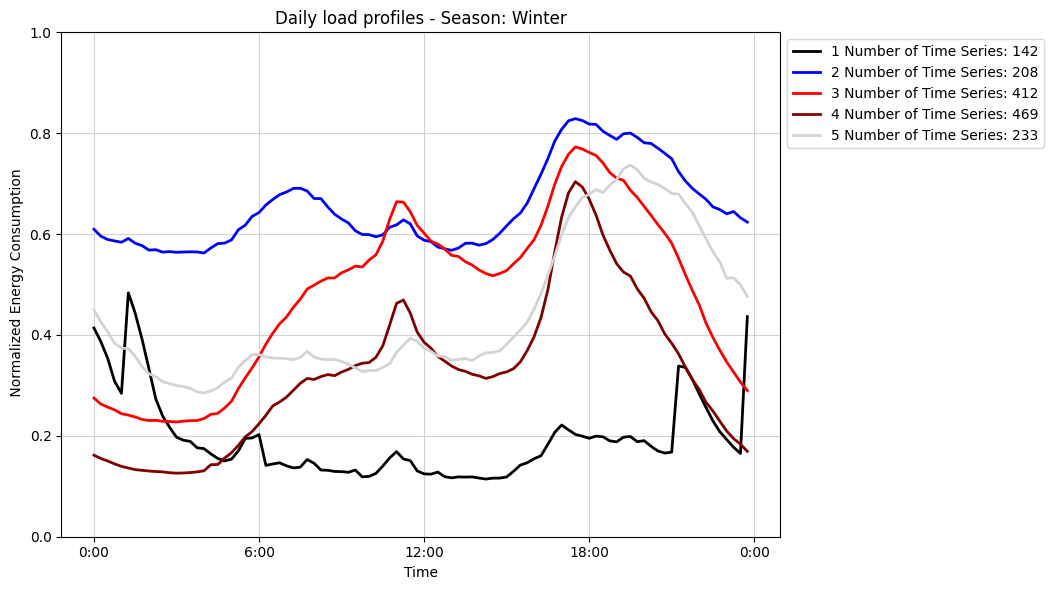

In [9]:
labels = ['0:00','6:00','12:00','18:00','0:00']

colors= ['black','blue','red','maroon','lightgrey','pink','darkgrey','darkblue','skyblue','indianred','purple','magenta','pink','violet']

def plot_clusters_season():
    
    plt.figure(figsize=(8,6))
    for cluster_idx in range(n_clusters):
        # Get all time series in this cluster
        cluster_data = train_data[clusters_train == cluster_idx]
        cluster_indices = np.where(clusters_train == cluster_idx)[0]    
    
        # Calculate the mean time series for the cluster
        mean_time_series = np.mean(cluster_data, axis=0)
    
        # Plot the mean time series
        cluster_no = cluster_idx+1
        plt.plot(range(1,97), mean_time_series.ravel(), 
                label= f'{cluster_no} Number of Time Series: {len(cluster_indices)}',
                linewidth =2, color=colors[cluster_idx] )
    plt.title(f'Daily load profiles - Season: {season.capitalize()}')
    plt.xlabel("Time")
    plt.ylabel(" Normalized Energy Consumption")
    plt.ylim(0,1)
    #plt.xticks(range(1,108,12),labels=labels)
    plt.xticks(range(1,120,24),labels=labels)
    plt.tight_layout()
    #plt.legend()
    #plt.margins(0)
    plt.grid(True, color = 'lightgray')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.savefig(
    "/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/Plots_seasonal/" \
    "seasonal_clusters_" + season + ".png",
    bbox_inches='tight',
    dpi=600
)
    plt.show()
    

plot_clusters_season()